# Imports

In [1]:
import json
from functools import reduce
from os import listdir
from os.path import isfile, join
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan

# Setup

In [2]:
# Set figure size
rcParams['figure.figsize'] = (4, 4)

# Folder for images
Path('img').mkdir(parents=True, exist_ok=True)

# Nice float format
pd.options.display.float_format = "{:,.6f}".format

# Data description

Last year I purchased a Polar watch that tracks my vitals during workouts. I used the [Polar Flow](polar.flow.com) website to obtain a copy of my data. For privacy reasons I shall not be sharing the dataset.

In [3]:
path = './data/'

First, we create a list of files in the download.

In [4]:
files = [f for f in listdir(path) if isfile(join(path, f))]

We shall only consider files containing the string `'training-session'`.

In [5]:
files = [f for f in files if 'training-session' in f]

The number of files under consideration is:

In [6]:
len(files)

284

We loop over each of the files and them to a list.

In [7]:
data = []

for f in files:
    with open(join(path, f)) as f:
        d = json.load(f)
        data.append(d)

We extract the relevant information from the items in the list.

In [8]:
workouts = []

for d in data:
    workouts.append(d['exercises'][0])

Finally we create a dataframe containing the workout information.

In [9]:
df = pd.DataFrame(workouts)

# Data structure

We find the following columns in the dataframe.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startTime       284 non-null    object 
 1   stopTime        284 non-null    object 
 2   timezoneOffset  284 non-null    int64  
 3   duration        284 non-null    object 
 4   sport           284 non-null    object 
 5   kiloCalories    283 non-null    float64
 6   heartRate       283 non-null    object 
 7   zones           284 non-null    object 
 8   samples         284 non-null    object 
 9   distance        130 non-null    float64
 10  latitude        130 non-null    float64
 11  longitude       130 non-null    float64
 12  ascent          120 non-null    float64
 13  descent         121 non-null    float64
 14  speed           130 non-null    object 
 15  autoLaps        102 non-null    object 
 16  laps            2 non-null      object 
dtypes: float64(6), int64(1), object(10)

We remove columns that containt data from features I do not use in my training.

Due to privacy concerns I shan't be extracting longitudinal and latitudinal data.

In [11]:
df = df.drop(['zones', 'samples', 'autoLaps', 
              'laps', 'latitude', 'longitude'], axis=1)

In [12]:
df.head()

,startTime,stopTime,timezoneOffset,duration,sport,kiloCalories,heartRate,distance,ascent,descent,speed
0,2019-05-24T13:18:14.000,2019-05-24T14:58:44.125,120,PT6030.125S,STRENGTH_TRAINING,658.000000,"{'min': 72, 'avg': 105, 'max': 136}",nan,nan,nan,NaN
1,2019-05-04T12:03:34.000,2019-05-04T13:21:38.500,120,PT4684.500S,STRENGTH_TRAINING,373.000000,"{'min': 71, 'avg': 99, 'max': 138}",nan,nan,nan,NaN
2,2019-04-12T12:48:57.000,2019-04-12T12:59:10.750,120,PT613.750S,TREADMILL_RUNNING,62.000000,"{'min': 71, 'avg': 97, 'max': 107}",nan,nan,nan,NaN
3,2019-06-12T13:13:09.000,2019-06-12T13:23:15.500,120,PT606.500S,TREADMILL_RUNNING,71.000000,"{'min': 67, 'avg': 105, 'max': 121}",nan,nan,nan,NaN
4,2019-05-24T14:59:06.000,2019-05-24T15:29:08.750,120,PT1802.750S,TREADMILL_RUNNING,416.000000,"{'min': 84, 'avg': 144, 'max': 170}",nan,nan,nan,NaN


# Missing Values

The watch tracks different information for different workouts. For example when walking it tracks location but when walking on a treadmill it doesn't, hence there is quite a lot of missing data.

In [13]:
missing = (df.isna().sum() / df.shape[0] * 100)
missing.name = 'Missing %'
missing = missing.to_frame()
missing = missing.sort_values('Missing %', ascending=False)
missing = missing[missing['Missing %'] > 0]
np.round(missing, 2)

,Missing %
ascent,57.750000
descent,57.390000
distance,54.230000
speed,54.230000
kiloCalories,0.350000
heartRate,0.350000


# Transforms

We apply certain transforms to make the data easier to work with. First we convert strings to datetimes.

In [14]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['stopTime'] = pd.to_datetime(df['stopTime'])

We calculate the total duration of each individual workout in minutes.

In [15]:
df['totalTime'] = (df['stopTime'] - df['startTime'])
df['totalTime'] = df['totalTime'].apply(lambda x: round(x.seconds / 60, 2))
df.drop('duration', axis=1, inplace=True)

We split the datetime columns in to date and time.

In [16]:
df['startDate'] = pd.to_datetime(df['startTime']).dt.date
df['stopDate'] = pd.to_datetime(df['stopTime']).dt.date
df['startTime'] = pd.to_datetime(df['startTime']).dt.time
df['stopTime'] = pd.to_datetime(df['stopTime']).dt.time

We extract maximum, average and minimum heart rate values from the `heartRate` column.

In [17]:
df['heartRateMax'] = df['heartRate'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df['heartRateAvg'] = df['heartRate'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['heartRateMin'] = df['heartRate'].apply(lambda x: x['min'] if isinstance(x, dict) else np.nan)
df.drop('heartRate', axis=1, inplace=True)

In a similar manner we extract the maximum, average and minimum values form the `speed` column.

In [18]:
df['speedAvg'] = df['speed'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['speedMax'] = df['speed'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df.drop('speed', axis=1, inplace=True)

We reorder the data as follows.

In [19]:
order = ['startDate',
         'stopDate',
         'startTime',
         'stopTime',
         'timezoneOffset',
         'totalTime', 
         'sport',
         'kiloCalories',
         'heartRateMax',
         'heartRateAvg',
         'heartRateMin']

In [20]:
df = df[order]

We check if there are any more `NaN`'s in the data.

In [21]:
df.isna().sum()

startDate         0
stopDate          0
startTime         0
stopTime          0
timezoneOffset    0
totalTime         0
sport             0
kiloCalories      1
heartRateMax      1
heartRateAvg      1
heartRateMin      1
dtype: int64

There is one row with `NaN`'s. This might due to my watch having little battery left to make the measurements.

In [22]:
df = df.dropna()

Finally we proceed to sort the data with the latest workouts at the top of the dataframe.

In [23]:
sort_cols = ['startDate','startTime']
df = df.sort_values(sort_cols, ascending=False)
df = df.reset_index(drop=True)

In [24]:
df.head()

,startDate,stopDate,startTime,stopTime,timezoneOffset,totalTime,sport,kiloCalories,heartRateMax,heartRateAvg,heartRateMin
0,2020-03-29,2020-03-29,21:50:21,22:23:41.750000,120,33.330000,WALKING,245.000000,116.000000,102.000000,69.000000
1,2020-03-27,2020-03-27,20:38:32,21:25:03.750000,60,46.520000,WALKING,401.000000,132.000000,104.000000,70.000000
2,2020-03-26,2020-03-26,21:07:46,21:52:55.625000,60,45.150000,WALKING,336.000000,122.000000,103.000000,87.000000
3,2020-03-25,2020-03-25,19:22:38,20:10:17.875000,60,47.650000,WALKING,380.000000,125.000000,108.000000,87.000000
4,2020-03-24,2020-03-24,13:09:06,13:48:46.750000,60,39.670000,WALKING,358.000000,141.000000,117.000000,90.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startDate       283 non-null    object 
 1   stopDate        283 non-null    object 
 2   startTime       283 non-null    object 
 3   stopTime        283 non-null    object 
 4   timezoneOffset  283 non-null    int64  
 5   totalTime       283 non-null    float64
 6   sport           283 non-null    object 
 7   kiloCalories    283 non-null    float64
 8   heartRateMax    283 non-null    float64
 9   heartRateAvg    283 non-null    float64
 10  heartRateMin    283 non-null    float64
dtypes: float64(5), int64(1), object(5)
memory usage: 24.4+ KB


# Analysis

Given that we have produced a clean dataset we can proceed to analyse a few aspects.

## Time span

The date of the first workout is:

In [26]:
str(df['startDate'].min())

'2019-02-20'

The date of the last workout is:

In [27]:
str(df['startDate'].max())

'2020-03-29'

Workouts measured:

In [28]:
len(df)

283

## Descriptive statistics

In [29]:
df.drop('timezoneOffset', axis=1).describe()

,totalTime,kiloCalories,heartRateMax,heartRateAvg,heartRateMin
count,283.000000,283.000000,283.000000,283.000000,283.000000
mean,42.831060,315.975265,128.335689,105.194346,76.738516
std,29.647283,218.745576,18.254807,11.866621,8.987117
min,5.000000,29.000000,93.000000,82.000000,53.000000
25%,15.920000,121.500000,115.000000,96.000000,70.000000
50%,36.450000,277.000000,125.000000,103.000000,77.000000
75%,65.290000,441.500000,138.500000,111.000000,83.000000
max,172.730000,"1,067.000000",178.000000,148.000000,99.000000


## Kilocalories burned in total

First we count the total kilocalories I burned during the period in question.

In [30]:
total_calories = df['kiloCalories'].sum()
print(total_calories)

89421.0


We convert this number to kilograms of body fat.
According to [this article](https://www.livestrong.com/article/304137-how-many-calories-per-kilogram-of-weight/) it equates to

In [31]:
total_calories / 7700

11.613116883116883

## Kilocalories burned by sport

In [32]:
by_sport = df[['kiloCalories', 'sport']].groupby('sport', as_index=False)
by_sport = by_sport.sum()
by_sport['sport'] = by_sport['sport'].apply(lambda x: x.lower())
by_sport['kiloCalories'] = by_sport['kiloCalories'].astype(int)
by_sport = by_sport.rename(columns={'kiloCalories': 'total kilocalories'})
by_sport = by_sport.sort_values('total kilocalories', ascending=False)
by_sport

,sport,total kilocalories
4,walking,33080
2,strength_training,31547
3,treadmill_running,19825
0,cycling,4029
1,running,940


## Kilocalories burned over time

Next we produce a plot of kilocalories burned over a two month period in 2019.

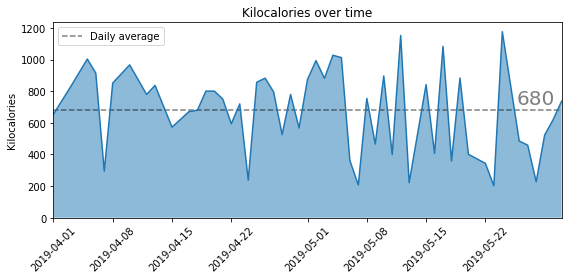

In [33]:
width = 800
height = 400
dpi = 100

start = pd.to_datetime('2019-04-1') 
stop = pd.to_datetime('2019-06-1')

daily = df[['startDate', 'kiloCalories']]
mask = (daily['startDate'] >= start) & (daily['startDate'] < stop)
daily = daily[mask]
daily = daily.groupby('startDate', as_index=False)
daily = daily.sum()
daily = daily.sort_values('startDate', ascending=False)
daily = daily.reset_index(drop=True)

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(daily['startDate'], daily['kiloCalories'])

plt.fill_between(x=daily['startDate'], 
                 y1=0, 
                 y2=daily['kiloCalories'], 
                 alpha=1/2)

plt.hlines(xmin=daily['startDate'].min(),
           xmax=daily['startDate'].max(),
           y=daily['kiloCalories'].mean(),
           linestyle='dashed',
           label='Daily average',
           alpha=1/2)

plt.text(x=daily.loc[3, 'startDate'],
         y=daily['kiloCalories'].mean() + 75,
         s=round(daily['kiloCalories'].mean()),
         verticalalignment='center',
         horizontalalignment='center',
         alpha=1/2,
         fontsize=20)

plt.title('Kilocalories over time')
plt.xticks(rotation=45, horizontalalignment='center')
plt.xlim(daily['startDate'].min(), daily['startDate'].max())
plt.ylim(0, daily['kiloCalories'].max() * 1.05)
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./img/kilocalories_ts.png')
plt.show()

## Workouts by sport

We check how many workouts I completed.

In [34]:
stats = df[['sport', 'startTime']]
stats = stats.groupby(['sport'], as_index=False)
stats = stats.count()
stats = stats.rename(columns={'sport': 'Sport', 
                              'startTime': 'Count'})
stats = stats.sort_values('Count', ascending=False)
stats.head()

,Sport,Count
4,WALKING,105
3,TREADMILL_RUNNING,90
2,STRENGTH_TRAINING,62
0,CYCLING,24
1,RUNNING,2


## By hour of day

We count workouts by hour of day.

In [35]:
by_hour = df[['startTime', 'sport']].copy()
by_hour['startTime'] = pd.to_datetime(by_hour['startTime'], format='%H:%M:%S')
by_hour['startHour'] = by_hour['startTime'].dt.hour
by_hour = by_hour.drop('startTime', axis=1)
by_hour = by_hour.groupby('startHour', as_index=False)
by_hour = by_hour.count()

all_hours = pd.DataFrame(range(0, 24), columns=['startHour'])

by_hour = pd.merge(all_hours, by_hour, how='left')
by_hour = by_hour.fillna(0)
by_hour = by_hour.sort_values('startHour')
by_hour = by_hour.rename(columns={'startHour': 'Hour of day', 
                                 'sport': 'Total workouts'})

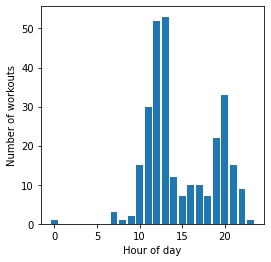

In [36]:
plt.bar(by_hour['Hour of day'], by_hour['Total workouts'])
plt.ylabel('Number of workouts')
plt.xlabel('Hour of day')
plt.savefig('./img/workouts_by_hour_of_day.png')
plt.show()

## By day of week

We count workouts by day of week.

In [37]:
by_day = df[['startDate', 'sport']].copy()
by_day['Day of week'] = pd.to_datetime(by_day['startDate']).dt.day_name()
by_day['Day number'] = pd.to_datetime(by_day['startDate']).dt.dayofweek
by_day = by_day.groupby(['Day of week', 'Day number'], as_index=False)
by_day = by_day.count()
by_day = by_day.drop('startDate', axis=1)
by_day = by_day.sort_values('Day number')
by_day = by_day.rename(columns={'sport': 'Total Workouts'})

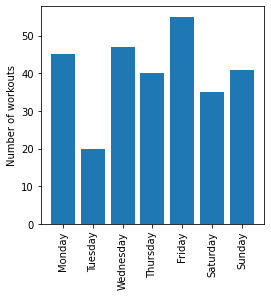

In [38]:
plt.bar(by_day['Day of week'], by_day['Total Workouts'])
plt.xticks(rotation=90)
plt.ylabel('Number of workouts')
plt.savefig('./img/workouts_by_day_of_week.png')
plt.show()

## Walks

We plot `totalTime` versus `kiloCalories`. As can be seen their seems to exist a linear relationship between the two.

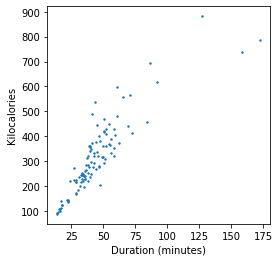

In [39]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['totalTime'], walking['kiloCalories'], s=2)
plt.xlabel('Duration (minutes)')
plt.ylabel('Kilocalories')
plt.savefig('./img/kilocalories_vs_time.png')
plt.show()

We plot `heartRateAvg` against `kiloCalories`. Again we see a linear relationship although there are a couple of outliers

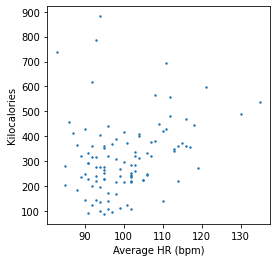

In [40]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['heartRateAvg'], walking['kiloCalories'], s=2)
plt.ylabel('Kilocalories')
plt.xlabel('Average HR (bpm)')
plt.savefig('./img/kilocalories_vs_avg_hr.png')
plt.show()

# Regression

Now we proceed to build a regression model to predict `kiloCalories` burned during a workout based on the numeric features `totalTime` and `heartRateAvg` ie the total duration of the workout and the average heart rate.

In [41]:
X = df[['kiloCalories', 'totalTime', 'heartRateAvg']].copy()

First we visualize histograms of each of the variables.

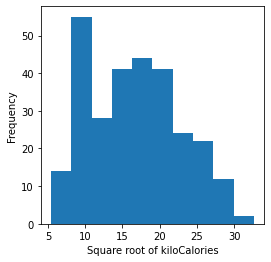

In [42]:
plt.hist(np.sqrt(X['kiloCalories']))
plt.ylabel('Frequency')
plt.xlabel('Square root of kiloCalories')
plt.savefig('./img/kilocalories_histogram.png')
plt.show()

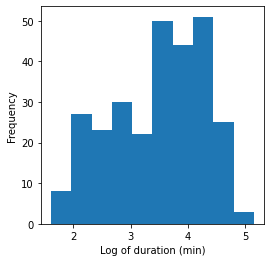

In [43]:
plt.hist(np.log(X['totalTime']))
plt.ylabel('Frequency')
plt.xlabel('Log of duration (min)')
plt.savefig('./img/duration_histogram.png')
plt.show()

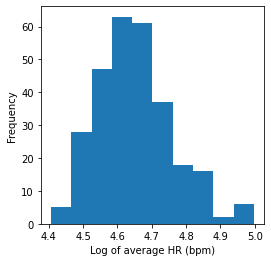

In [44]:
plt.hist(np.log(X['heartRateAvg']))
plt.ylabel('Frequency')
plt.xlabel('Log of average HR (bpm)')
plt.savefig('./img/average_hr_histogram.png')
plt.show()

The model we shall fit is:

$\sqrt{c_{i}} = \beta_{1} \ln{t_{i}} + \beta_{2} \ln{h_{i}} + \varepsilon_{i}$

Where:
* $c_{i}$ - The $i$-th `kiloCalories` value.
* $t_{i}$ - The $i$-th `totalTime` value.
* $h_{i}$ - The $i$-th `heartRateAvg` value.

In [45]:
X['kiloCalories'] = np.sqrt(X['kiloCalories'])
X['totalTime'] = np.sqrt(X['totalTime'])
X['heartRateAvg'] = np.log(X['heartRateAvg'])

We inspect the correlation matrix to check for multicollinearity. It should be noted that the correlation between `kiloCalories` and `totalTime` is quite high and this to be expected.

In [46]:
C = X.corr(method='pearson')
C = C.style.background_gradient(cmap='coolwarm')
C = C.set_precision(2)
C = C.set_table_attributes('style="font-size: 15px"')
C

,kiloCalories,totalTime,heartRateAvg
kiloCalories,1.00,0.93,0.26
totalTime,0.93,1.00,-0.05
heartRateAvg,0.26,-0.05,1.00


Next we perform the regression.

In [47]:
y = X[['kiloCalories']]
X = X.drop('kiloCalories', axis=1)

mdl = sm.OLS(y, X)
res = mdl.fit()

residuals = res.resid

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           kiloCalories   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              8966.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):                   2.87e-255
Time:                        23:52:53   Log-Likelihood:                         -625.71
No. Observations:                 283   AIC:                                      1255.
Df Residuals:                     281   BIC:                                      1263.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

We note that the value of the Durbin-Watson test statistic is approximately $2$, as it should be.
We proceed to inspect the residuals of the model. First we view the histogram of the residuals.

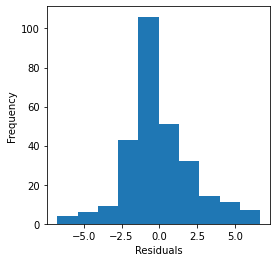

In [48]:
plt.hist(residuals)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.savefig('./img/mdl_residuals.png')
plt.show()

The next plot is a qqplot created to visually inspect the normality of the residuals.

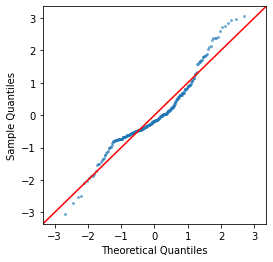

In [49]:
plt.figure()
ax = plt.gca()
qqplot(res.resid, ax=ax, color='#1f77b4', markersize=2, line='45', fit=True, alpha=1/2)
plt.savefig('./img/mdl_qq.png')
plt.show()

The 3 plot we make is a plot of the standardized residuals to check for homoskedasticity.

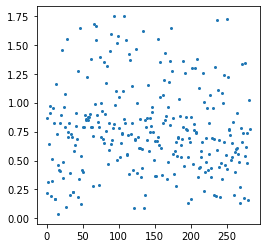

In [50]:
residuals_std = np.sqrt(np.abs((residuals - np.mean(residuals)) / np.std(residuals)))
plt.plot(residuals_std, 'o', markersize=2)
plt.savefig('./img/mdl_residuals_std.png')
plt.show()

Finally we compare the predicted `kiloCalories` with the actual values.

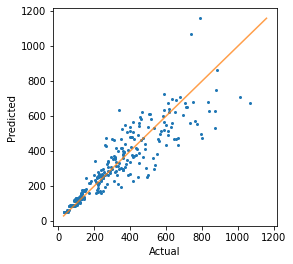

In [51]:
y_pred = res.predict(X)
y_pred = y_pred.to_numpy().reshape(len(y_pred))
y_true = y.to_numpy().reshape(len(y),)

m = np.min(np.hstack([y_true, y_pred]))
M = np.max(np.hstack([y_true, y_pred]))

x = np.linspace(np.power(m, 2), np.power(M, 2), len(y))
plt.plot(np.power(y_true, 2), np.power(y_pred,2), 'o', markersize=2)
plt.plot(x,x, alpha=3/4)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.savefig('./img/mdl_predicted_vs_actual.png')
plt.show()

In [52]:
X['totalTime'] = np.power(X['totalTime'], 2)
X['heartRateAvg'] = np.exp(X['heartRateAvg'])
X['y_true'] = np.power(y, 2)
X['y_pred'] = np.power(y_pred, 2)
X['e'] = X['y_true'] - X['y_pred']
X = X.sort_values('e', ascending=False)

In [53]:
X.head()

,totalTime,heartRateAvg,y_true,y_pred,e
93,96.920000,128.000000,"1,067.000000",674.706539,392.293461
237,75.150000,129.000000,870.000000,531.796222,338.203778
251,66.620000,130.000000,801.000000,475.501979,325.498021
154,102.000000,121.000000,"1,013.000000",706.971271,306.028729
173,69.650000,129.000000,795.000000,495.456319,299.543681


We now move on to performing statistical tests for normality and homoskedasticity.

In [54]:
def hypothesis_decision(x, alpha=0.05):
    if x < alpha:
        return 'Reject null hypothesis'
    else:
        return 'Fail to reject hypothesis'

First we carry out the Shapiro-Wilks test for normality. The hypotheses are:

$H_{0} :$ Data comes from a normal distribution.

$H_{1} :$ Data does not come from a normal distribution.

In [55]:
_,shapiro_pval = shapiro(residuals)

The second test we perform is the Breusch-Pagan for homoscedasticity. The hypotheses are:

$H_{0} :$ Homoscedasticity.

$H_{1} :$ Lack of homoscedasticity / Heteroskedasticity.

In [56]:
_,_,_,breusch_pval = het_breuschpagan(residuals, X)

We summarize the outcomes of the tests in a nice table.

In [57]:
pvalues = [shapiro_pval, breusch_pval]
name = ['Shapiro-Wilks', 'Breusch-Pagan',]
null_hyp = ['Normality', 'Heteroskedasticity']

tests = pd.DataFrame([name, null_hyp, pvalues], 
                     index=['Name', 'Null Hypothesis', 'P-value'])

tests = tests.transpose()
tests['Decision'] = tests['P-value'].apply(hypothesis_decision)
tests

,Name,Null Hypothesis,P-value,Decision
0,Shapiro-Wilks,Normality,0.000000,Reject null hypothesis
1,Breusch-Pagan,Heteroskedasticity,0.000000,Reject null hypothesis


# Model

Since we have succesfully obtained estimates for the $\beta_{i}$ coefficients for `totalTime`:

In [58]:
b1 = np.round(res.params['totalTime'], 4)
b1

2.4806

and for `heartRateAvg`:

In [59]:
b2 = np.round(res.params['heartRateAvg'], 4)
b2

0.3203

It's now time for a bit of algebra.

\begin{align}
\sqrt{c} &= \beta_{1} \sqrt{t} + \beta_{2} \ln{h} \\
c &= \big( \beta_{1} \sqrt{t} + \beta_{2} \ln{h} \big)^{2} \\
c &= \big(\beta_{1} \sqrt{t} \big)^{2} + 2\beta_{1} \beta_{2} \sqrt{t}  \ln(h) + \big( \beta_{2} \ln{h} \big)^{2} \\
c &= \beta_{1}^{2} t + 2\beta_{1} \beta_{2} \sqrt{t} \ln{h} + \beta_{2}^{2} \ln^{2}{h}
\end{align}

After these calculations we may state that `kiloCalories` $c$ as a function of `totalTime` $t$ ( in minutes) and `heartRateAvg` $h$ (in bpm) after substituting the $\beta_{i}$ coefficients is given by:

\begin{equation}
c(t,h) = 6.1534 t + 1.5890 \sqrt{t} \ln{h} + 0.1026 \ln^{2}{h}
\end{equation}

We restrict the functions domain to values observed in the data:

\begin{align}
5 &\leq  &&t &\leq 172 \\
82 &\leq &&h &\leq 148 \\
\end{align}

Next we define a function as described above to make a plot and see how does time and average heart rate impact the predictions.

In [60]:
def kilocalories(t, h):
    res = np.power(b1, 2) * t
    res += 2 * b1 * b2 * np.sqrt(t) * np.log(h)
    res += np.power(b2, 2) * np.power(np.log(h), 2)
    return np.round(res, 2)

As can be seen the total duration of the workout has an overwhelming influence on the predictions.

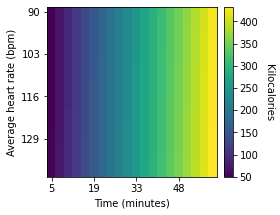

In [61]:
n = 5
t = np.linspace(5, 60, 20)
h = np.linspace(90, 140, 20)

cols = [str(int(x)) for x in list(t)]
rows = [str(int(x)) for x in list(h)]

t,h = np.meshgrid(t, h)

c = kilocalories(t, h)
c = pd.DataFrame(c, columns=cols, index=rows)

plt.imshow(c)
plt.ylabel('Average heart rate (bpm)')
plt.xlabel('Time (minutes)')
plt.xticks(ticks=range(len(cols))[::n], labels=cols[::n])
plt.yticks(ticks=range(len(rows))[::n], labels=rows[::n])
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Kilocalories', rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig('./img/mdl_grid.png')
plt.show()

# Summary

* I downloaded data generated by my Polar watch that tracks heart rate and estimates burned calories during workouts. 
* The data came in the form of “.json” files which were read, transformed and cleaned with `pandas`. 
* The clean dataset contains 283 workouts over a nearly one year period. 
* A linear regression model was built using `statsmodels` to predict the total `kilocalorie` expenditure based on the `duration` of the session and the `average heart rate`.
* After further transforming the data, the duration of a workout and kilocalories burned have 0.93 correlation. 
* The estimated formula is: `calories ^ (1/2) = 2.4806 * time ^ (1/2) + 0.3203 * log( heart rate )`
* Both variables turned out to be statistically significant, although the impact of heart rate is small.
* The biggest errors made by the model were on high `duration` workouts.